# Open source data ingestion for RAGs with dlt

Video: https://www.youtube.com/watch?v=qUNyfR_X2Mo

In this hands-on workshop, we’ll learn how to build a data ingestion pipeline using dlt to load data from a REST API into LanceDB so you can have an always up to date RAG.

​We’ll cover the following steps:

* Extract data from REST APIs
* Loading and vectorizing into LanceDB, which unlike other vector DBs stores the data _and_ the embeddings
* Incremental loading

​By the end of this workshop, you’ll be able to write a portable, OSS data pipeline for your RAG that you can deploy anywhere, such as python notebooks, virtual machines, or orchestrators like Airflow, Dagster or Mage.


# Resources

* Slides: [dlt-LLM-Zoomcamp.pdf](https://github.com/user-attachments/files/16131729/dlt.LLM.Zoomcamp.pdf)
* [Google Colab notebook](https://colab.research.google.com/drive/1nNOybHdWQiwUUuJFZu__xvJxL_ADU3xl?usp=sharing) - make a copy to follow along!

--- 

# Homework

In the workshop, we extracted contents from two pages in notion titled "Workshop: Benefits and Perks" and "Workshop: Working hours, PTO, and Vacation". 

Repeat the same process for a third page titled "Homework: Employee handbook" (hidden from public view, but accessible via API key):

1. Modify the REST API source to extract only this page.
2. Write the output into a separate table called "homework".
3. Remember to update the table name in all cells where you connect to a lancedb table.

To do this you can use the [workshop Colab](https://colab.research.google.com/drive/1nNOybHdWQiwUUuJFZu__xvJxL_ADU3xl?usp=sharing) as a basis.

Now, answer the following questions:

In [6]:
%%capture
!pip install dlt[lancedb]==0.5.1a0
!pip install sentence-transformers

In [7]:
!tar -xzvf lancedb.tar.gz

.lancedb/
.lancedb/qanda____dlt_pipeline_state.lance/
.lancedb/qanda____dlt_pipeline_state.lance/_latest.manifest
.lancedb/qanda____dlt_pipeline_state.lance/data/
.lancedb/qanda____dlt_pipeline_state.lance/data/f82c6be0-ecda-4adc-8177-6acd7fa5e1e8.lance
.lancedb/qanda____dlt_pipeline_state.lance/_transactions/
.lancedb/qanda____dlt_pipeline_state.lance/_transactions/0-838880c2-b9b4-41e1-8568-a4d610f48677.txn
.lancedb/qanda____dlt_pipeline_state.lance/_transactions/1-b166de74-4d8a-43c4-b2eb-74702dd1b885.txn
.lancedb/qanda____dlt_pipeline_state.lance/_versions/
.lancedb/qanda____dlt_pipeline_state.lance/_versions/2.manifest
.lancedb/qanda____dlt_pipeline_state.lance/_versions/1.manifest
.lancedb/qanda_embedded____dlt_pipeline_state.lance/
.lancedb/qanda_embedded____dlt_pipeline_state.lance/_latest.manifest
.lancedb/qanda_embedded____dlt_pipeline_state.lance/data/
.lancedb/qanda_embedded____dlt_pipeline_state.lance/data/f3f9b75c-430e-4116-9fe2-3085caf777fc.lance
.lancedb/qanda_embedded___

In [8]:
import lancedb

db = lancedb.connect(".lancedb")

db.table_names()

['notion_homework____dlt_loads',
 'notion_homework____dlt_pipeline_state',
 'notion_homework____dlt_version',
 'notion_homework___dltSentinelTable',
 'notion_homework___homework',
 'qanda____dlt_loads',
 'qanda____dlt_pipeline_state',
 'qanda____dlt_version',
 'qanda___dltSentinelTable',
 'qanda___documents',
 'qanda_embedded____dlt_loads',
 'qanda_embedded____dlt_pipeline_state',
 'qanda_embedded____dlt_version',
 'qanda_embedded___dltSentinelTable',
 'qanda_embedded___documents']

## Q1. Rows in LanceDB



In [9]:
db = lancedb.connect(".lancedb")

dbtable = db.open_table("notion_homework___homework")

dbtable.to_pandas().shape

(17, 9)

How many rows does the lancedb table "notion_pages__homework" have?

* 14
* 15
* 16
* **17**


## Q2. Running the Pipeline: Last edited time

In the demo, we created an incremental dlt resource `rest_api_notion_incremental` that keeps track of `last_edited_time`. What value does it store after you've run your pipeline once? (Hint: you will be able to get this value by performing some aggregation function on the column `last_edited_time` of the table)

* `Timestamp('2024-07-05 22:34:00+0000', tz='UTC') (OR "2024-07-05T22:34:00.000Z")`
* **`Timestamp('2024-07-05 23:33:00+0000', tz='UTC') (OR "2024-07-05T23:33:00.000Z")`**
* `Timestamp('2024-07-05 23:52:00+0000', tz='UTC') (OR "2024-07-05T23:52:00.000Z")`
* `Timestamp('2024-07-05 22:56:00+0000', tz='UTC') (OR "2024-07-05T22:56:00.000Z")`

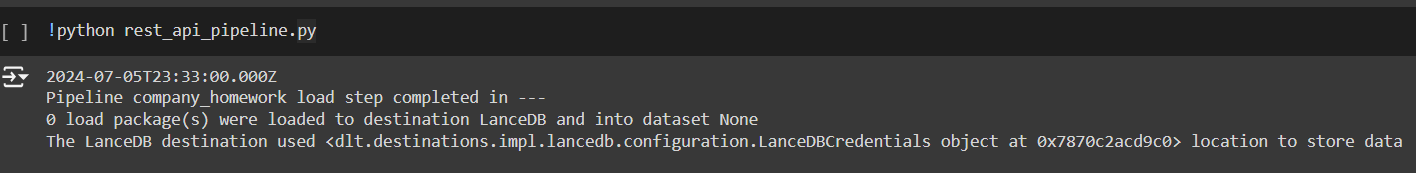

## Q3. Ask the Assistant 

Find out with the help of the AI assistant: how many PTO days are the employees entitled to in a year?  

* 20
* 25
* 30
* 35


In [13]:
!pip install ollama


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [14]:
import ollama

In [19]:
def retrieve_context_from_lancedb(dbtable, question, top_k=2):

    query_results = dbtable.search(query=question).to_list()
    context = "\n".join([result["content"] for result in query_results[:top_k]])

    return context

In [20]:
def main():
  # Connect to the lancedb table
  db = lancedb.connect(".lancedb")
  dbtable = db.open_table("notion_homework___homework")

  # A system prompt telling ollama to accept input in the form of "Question: ... ; Context: ..."
  messages = [
      {"role": "system", "content": "You are a helpful assistant that helps users understand policies inside a company's employee handbook. The user will first ask you a question and then provide you relevant paragraphs from the handbook as context. Please answer the question based on the provided context. For any details missing in the paragraph, encourage the employee to contact the HR for that information. Please keep the responses conversational."}
  ]

  while True:
    # Accept user question
    question = input("You: ")

    # Retrieve the relevant paragraphs on the question
    context = retrieve_context_from_lancedb(dbtable,question,top_k=2)

    # Create a user prompt using the question and retrieved context
    messages.append(
        {"role": "user", "content": f"Question: '{question}'; Context:'{context}'"}
    )

    # Get the response from the LLM
    response = ollama.chat(
        model="llama2-uncensored",
        messages=messages
    )
    response_content = response['message']['content']
    print(f"Assistant: {response_content}")

    # Add the response into the context window
    messages.append(
        {"role": "assistant", "content":response_content}
    )

In [22]:
#main()

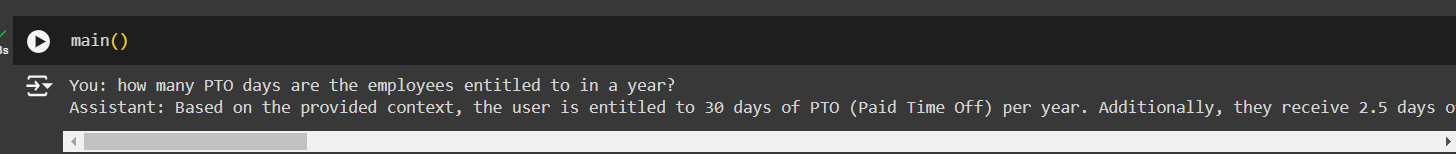

**You**: how many PTO days are the employees entitled to in a year?

**Assistant**: Based on the provided context, the user is entitled to 30 days of PTO (Paid Time Off) per year. Additionally, they receive 2.5 days of PTO per month and earn one additional day each year up to a cap of 25 days overall. If the employee wants to use their PTO, they must submit a request through the HRIS system and if approved by their manager or HR, can take leave without needing to specify a reason. However, if the user leaves the company before using all of their accrued PTO, they may receive compensation with their final paycheck according to local law. If there is no provision in local law, we encourage the employee to use their time off throughout the year. Finally, holidays are considered "off-days" for most employees and if an exempt employee works on a holiday, they will receive additional PTO days that must be taken within 12 months after that holiday.


* 20
* 25
* **30**
* 35
